In [1]:
import sys
import os

module_path = os.path.abspath(os.pardir)
if module_path not in sys.path:
    sys.path.append(module_path)
from src import choose_day_number, search_best_params, predict_best_model

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from xgboost import XGBRegressor

### Pollutants

In this section we can see polluntants plots and check outliers, if any.

In [2]:
country = 'ES'

In [3]:
df_co = pd.read_csv(f"../data/interim/cleaned/{country}_CO_cleaned.csv", parse_dates=['Datetime'], index_col=['Datetime'])
df_co

,Countrycode,Namespace,AirQualityNetwork,AirQualityStationEoICode,SamplingPoint,AirPollutant,Concentration,UnitOfMeasurement,DatetimeBegin,DatetimeEnd,Validity,Verification
Datetime,,,,,,,,,,,,
2020-01-01 01:00:00+01:00,ES,ES.BDCA.AQD,NET_ES213A,ES1563A,SP_28005002_6_48,CO,0.7,mg/m3,2020-01-01 00:00:00+01:00,2020-01-01 01:00:00+01:00,1,1
2020-01-01 02:00:00+01:00,ES,ES.BDCA.AQD,NET_ES213A,ES1563A,SP_28005002_6_48,CO,0.9,mg/m3,2020-01-01 01:00:00+01:00,2020-01-01 02:00:00+01:00,1,1
2020-01-01 03:00:00+01:00,ES,ES.BDCA.AQD,NET_ES213A,ES1563A,SP_28005002_6_48,CO,0.8,mg/m3,2020-01-01 02:00:00+01:00,2020-01-01 03:00:00+01:00,1,1
2020-01-01 04:00:00+01:00,ES,ES.BDCA.AQD,NET_ES213A,ES1563A,SP_28005002_6_48,CO,0.6,mg/m3,2020-01-01 03:00:00+01:00,2020-01-01 04:00:00+01:00,1,1
2020-01-01 05:00:00+01:00,ES,ES.BDCA.AQD,NET_ES213A,ES1563A,SP_28005002_6_48,CO,0.6,mg/m3,2020-01-01 04:00:00+01:00,2020-01-01 05:00:00+01:00,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-02 07:00:00+01:00,ES,ES.BDCA.AQD,NET_ES213A,ES1563A,SP_28005002_6_48,CO,0.3,mg/m3,2022-06-02 06:00:00+01:00,2022-06-02 07:00:00+01:00,1,3
2022-06-02 08:00:00+01:00,ES,ES.BDCA.AQD,NET_ES213A,ES1563A,SP_28005002_6_48,CO,0.3,mg/m3,2022-06-02 07:00:00+01:00,2022-06-02 08:00:00+01:00,1,3
2022-06-02 09:00:00+01:00,ES,ES.BDCA.AQD,NET_ES213A,ES1563A,SP_28005002_6_48,CO,0.3,mg/m3,2022-06-02 08:00:00+01:00,2022-06-02 09:00:00+01:00,1,3


<AxesSubplot:xlabel='Datetime'>

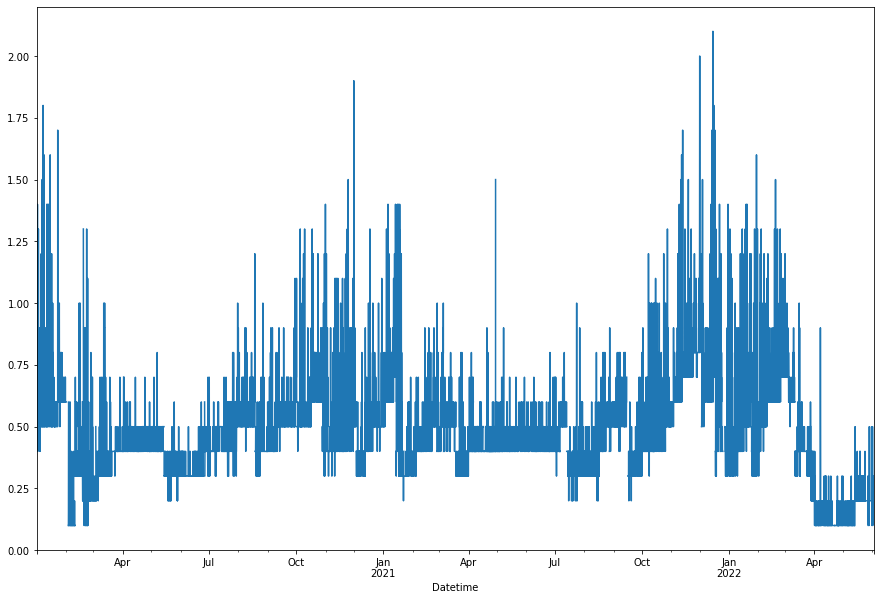

In [4]:
fig = plt.figure(figsize=(15, 10))
df_co["Concentration"].plot()

<AxesSubplot:xlabel='Datetime'>

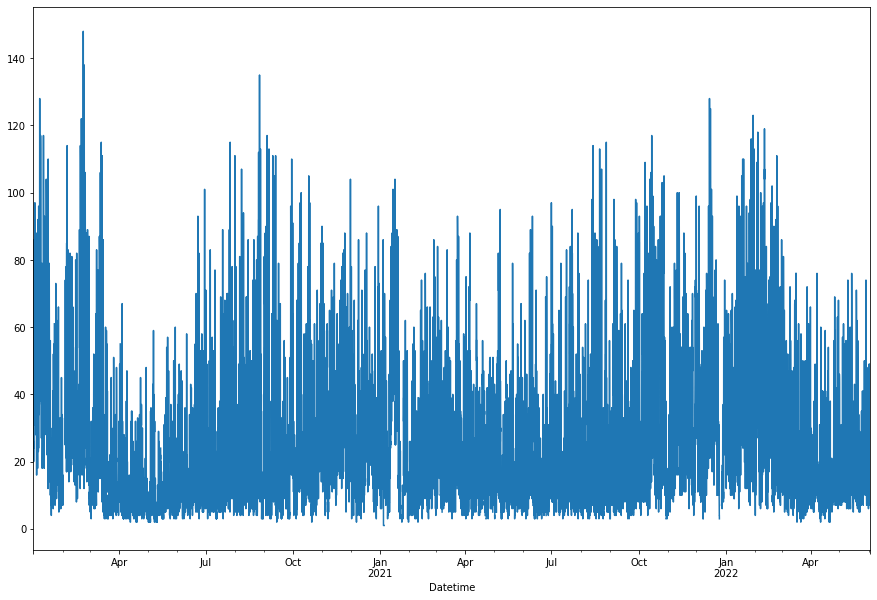

In [5]:
df_no2 = pd.read_csv(f"../data/interim/cleaned/{country}_NO2_cleaned.csv", parse_dates=['Datetime'], index_col=['Datetime'])
fig = plt.figure(figsize=(15, 10))
df_no2["Concentration"].plot()

<AxesSubplot:xlabel='Datetime'>

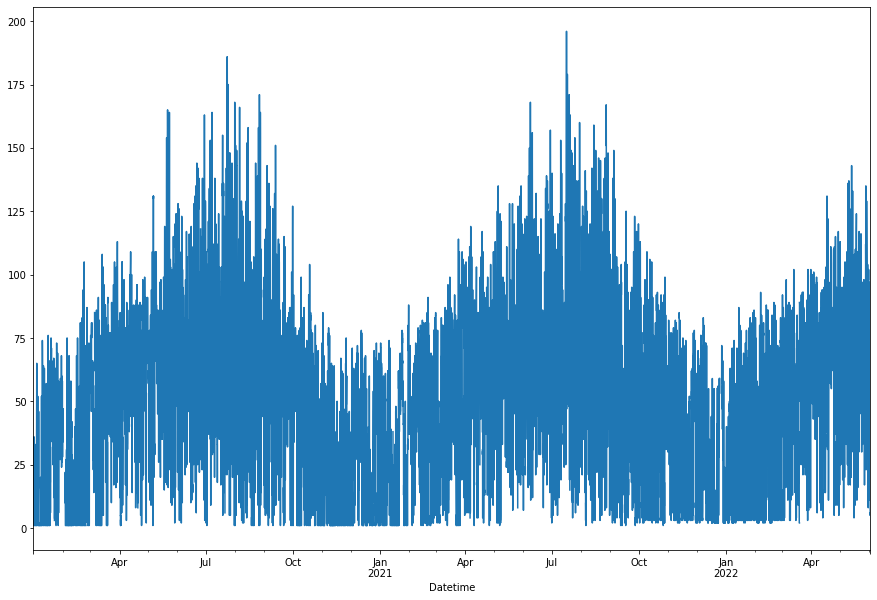

In [6]:
df_o3 = pd.read_csv(f"../data/interim/cleaned/{country}_O3_cleaned.csv", parse_dates=['Datetime'], index_col=['Datetime'])
fig = plt.figure(figsize=(15, 10))
df_o3["Concentration"].plot()

<AxesSubplot:xlabel='Datetime'>

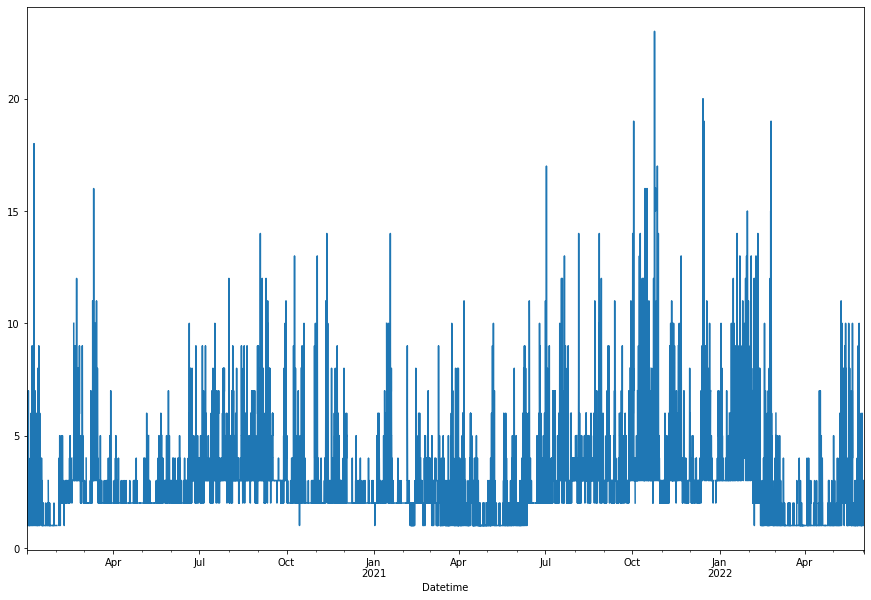

In [7]:
df_so2 = pd.read_csv(f"../data/interim/cleaned/{country}_SO2_cleaned.csv", parse_dates=['Datetime'], index_col=['Datetime'])
fig = plt.figure(figsize=(15, 10))
df_so2["Concentration"].plot()

There are many big values for PM10 and PM2.5. But we have to remember that its values can be above 500.

<AxesSubplot:xlabel='Datetime'>

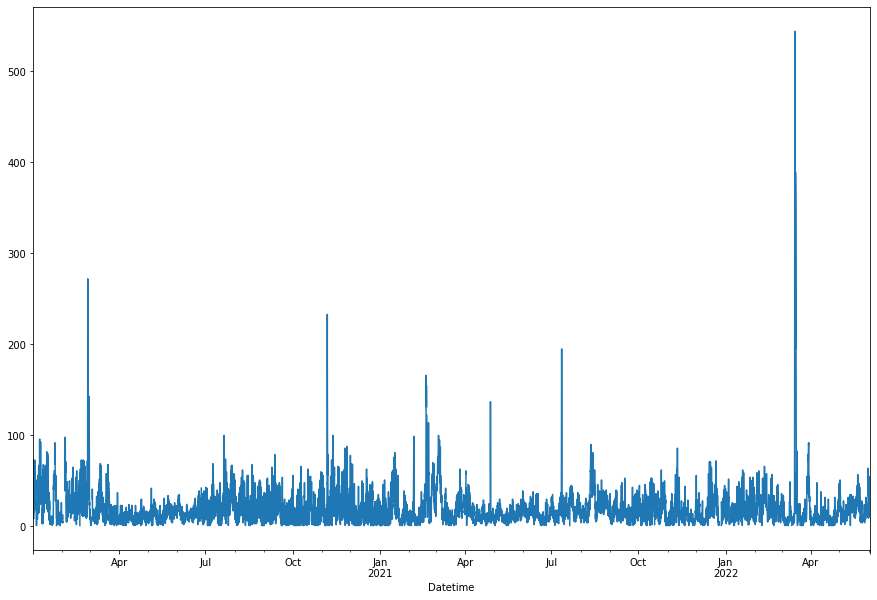

In [8]:
df_pm10 = pd.read_csv(f"../data/interim/cleaned/{country}_PM10_cleaned.csv", parse_dates=['Datetime'], index_col=['Datetime'])
fig = plt.figure(figsize=(15, 10))
df_pm10["Concentration"].plot()

<AxesSubplot:xlabel='Datetime'>

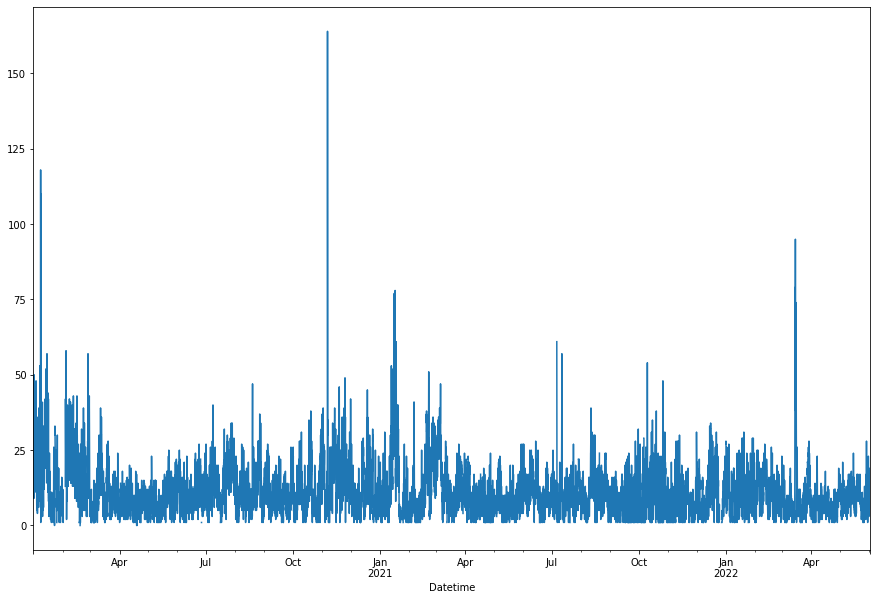

In [9]:
df_pm25 = pd.read_csv(f"../data/interim/cleaned/{country}_PM2.5_cleaned.csv", parse_dates=['Datetime'], index_col=['Datetime'])
fig = plt.figure(figsize=(15, 10))
df_pm25["Concentration"].plot()

Values for PM10 refer to PM2.5 values, this follows from PM definitions (particulate matter). So let's check if one pollutant has large value, whether the values of another pollutant are also large. Most often PM10 depends on PM2.5 more than PM2.5 on PM10.

In [15]:
df_pm25["Concentration"].max(), df_pm10.loc['2020-11-06 13:00:00+0100', "Concentration"]

(164.0, 230.0)

In [16]:
df_pm10["Concentration"].max(), df_pm25.loc['2022-03-15 09:00:00+0100', "Concentration"]

(544.0, 95.0)

### AQI

AQI - air quality index is the highest value calculated for each pollutant. For polutants are calculated subindex and then we choose the biggest one. 

It's AQI for 1 hour

<AxesSubplot:xlabel='Datetime'>

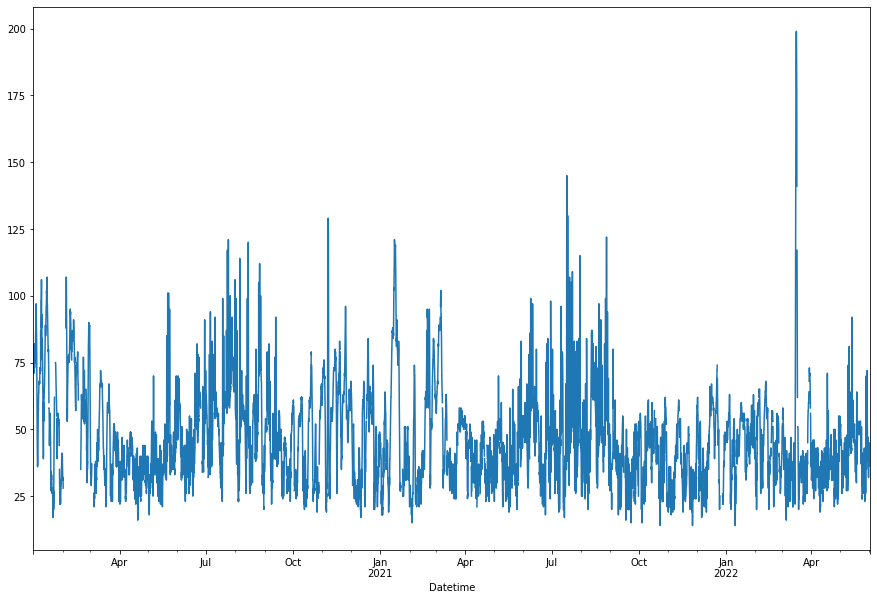

In [3]:
df_aqi = pd.read_csv("../data/processed/AQI_dataset.csv", parse_dates=['Datetime'], index_col=['Datetime'])
fig = plt.figure(figsize=(15, 10))
df_aqi["AQI"].plot()

We use daily AQI

<AxesSubplot:xlabel='Datetime'>

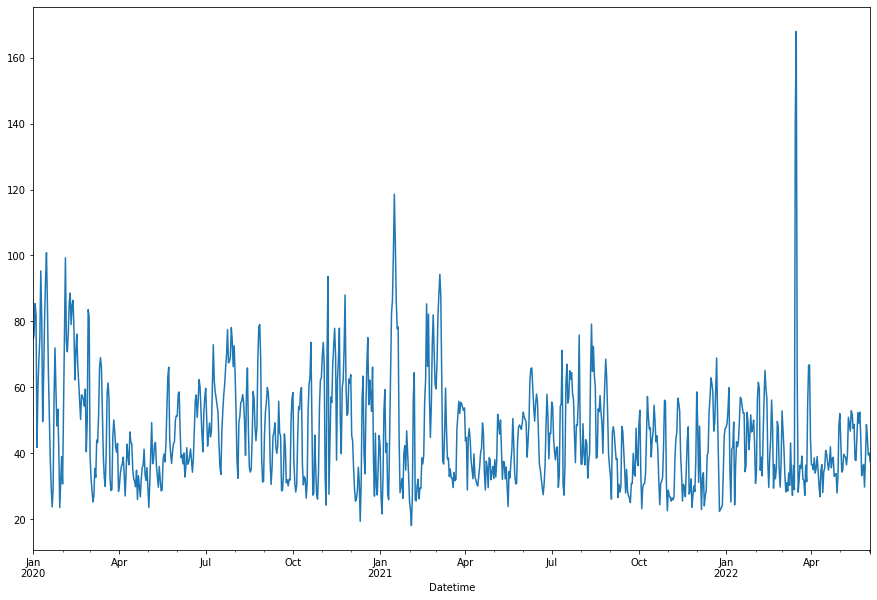

In [4]:
df_aqi_daily = df_aqi.resample('D').mean().interpolate()
fig = plt.figure(figsize=(15, 10))
df_aqi_daily["AQI"].plot()

***Time series analysis***

Stationarity

In [35]:
ADF_result = adfuller(df_aqi_daily["AQI"])   
print(f'ADF Statistic: {ADF_result[0]}') 
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -10.869053097432937
p-value: 1.383425557559172e-19


With a large negative ADF statistic and a p-value much smaller than 0.05, we can say that our series is stationary.

Autocorrelation

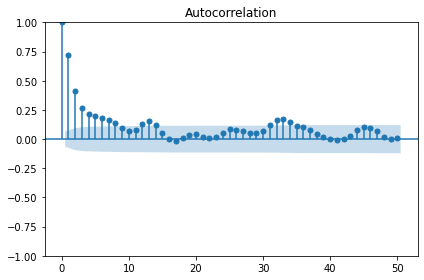

In [36]:
plot_acf(df_aqi_daily["AQI"], lags=50)
plt.tight_layout()

Significant autocorrelation for 7 lags (but some pick we see later)

/home/icelandic/.cache/pypoetry/virtualenvs/mlops-project-UMt4i_ZD-py3.9/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


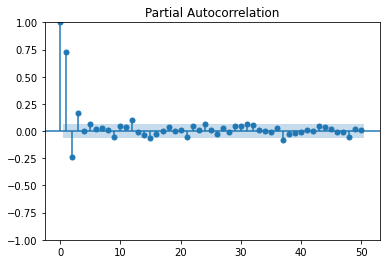

In [37]:
plot_pacf(df_aqi_daily["AQI"], lags=50)
plt.show()

Negative spikes every 7 lags 

Looks like autoregressive process 

<AxesSubplot:xlabel='Datetime'>

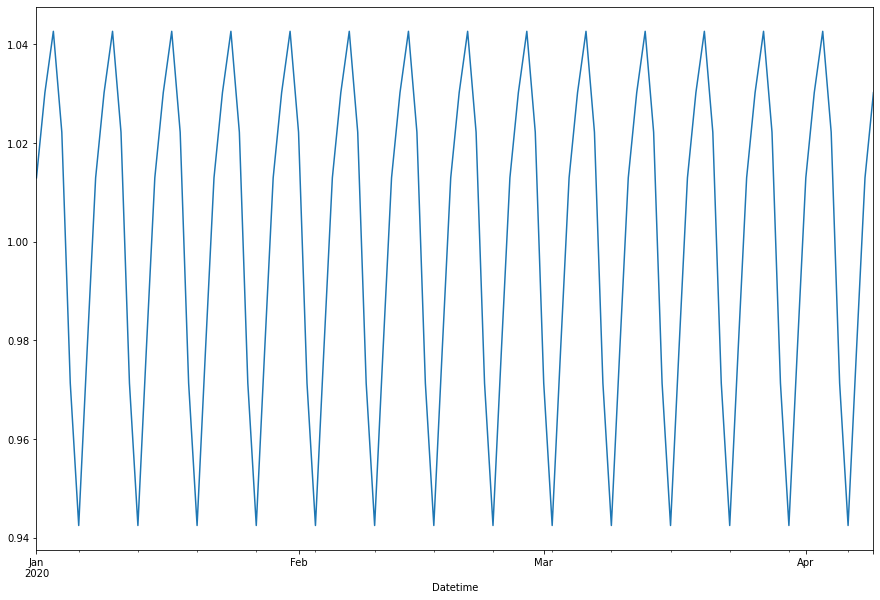

In [20]:
analysis = df_aqi_daily["AQI"].copy()


decompose_result_mult = seasonal_decompose(analysis, model="multiplicative")

trend = decompose_result_mult.trend
seasonal = decompose_result_mult.seasonal
residual = decompose_result_mult.resid

fig = plt.figure(figsize=(15, 10))
seasonal[:100].plot()

Looks like there is weekly seasonality

In [10]:
print("Mean: ", df_aqi_daily["AQI"].mean(), "\nSTD: ", df_aqi_daily["AQI"].std(), "\nMedian: ", df_aqi_daily["AQI"].median())

Mean:  45.828011182759425 
STD:  16.238174670153402 
Median:  42.62280701754386


<AxesSubplot:ylabel='AQI'>

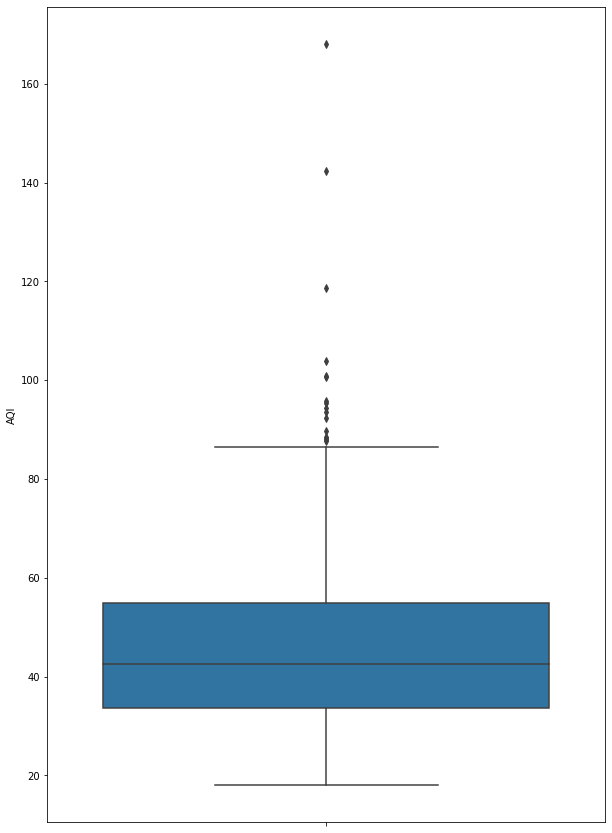

In [11]:
fig = plt.figure(figsize=(10, 15))
sns.boxplot(y=df_aqi_daily["AQI"])

### ***Baseline Naive Algorithm***

In [12]:
pd.concat([df_aqi_daily["AQI"].shift(1), df_aqi_daily["AQI"]], axis=1).dropna()

,AQI,AQI
Datetime,,
2020-01-02 00:00:00+01:00,89.739130,76.208333
2020-01-03 00:00:00+01:00,76.208333,85.375000
2020-01-04 00:00:00+01:00,85.375000,81.791667
2020-01-05 00:00:00+01:00,81.791667,41.708333
2020-01-06 00:00:00+01:00,41.708333,59.916667
...,...,...
2022-05-29 00:00:00+01:00,38.166667,48.625000
2022-05-30 00:00:00+01:00,48.625000,44.875000
2022-05-31 00:00:00+01:00,44.875000,39.409091


In [13]:
values = pd.DataFrame(df_aqi_daily["AQI"].values)
df_naive = pd.concat([values.shift(1), values], axis=1).dropna()
df_naive.columns = ['t-1', 't+1']
df_naive

,t-1,t+1
1,89.739130,76.208333
2,76.208333,85.375000
3,85.375000,81.791667
4,81.791667,41.708333
5,41.708333,59.916667
...,...,...
879,38.166667,48.625000
880,48.625000,44.875000
881,44.875000,39.409091
882,39.409091,40.000000


For 5 days Naive

In [14]:
train, test = df_naive[1:-5], df_naive[-5:]
train_X, train_y = train["t-1"], train["t+1"]
test_X, test_y = test["t-1"], test["t+1"]

In [15]:
predictions = test_X.apply(lambda x: x)
test_rmse = mean_squared_error(test_y, predictions, squared=False)
print('Test RMSE: %.3f' % test_rmse)

Test RMSE: 5.655


For 20% test size

In [16]:
train_size = int(df_naive.shape[0] * 0.75)
train, test = df_naive[1:train_size], df_naive[train_size:]
train_X, train_y = train["t-1"], train["t+1"]
test_X, test_y = test["t-1"], test["t+1"]

In [17]:
predictions = test_X.apply(lambda x: x)
test_rmse = mean_squared_error(test_y, predictions, squared=False)
test_mae = mean_absolute_error(test_y, predictions)
print("Test RMSE: %.3f" % test_rmse, "\nTest MAE: %.3f" % test_mae)

Test RMSE: 14.341 
Test MAE: 8.116


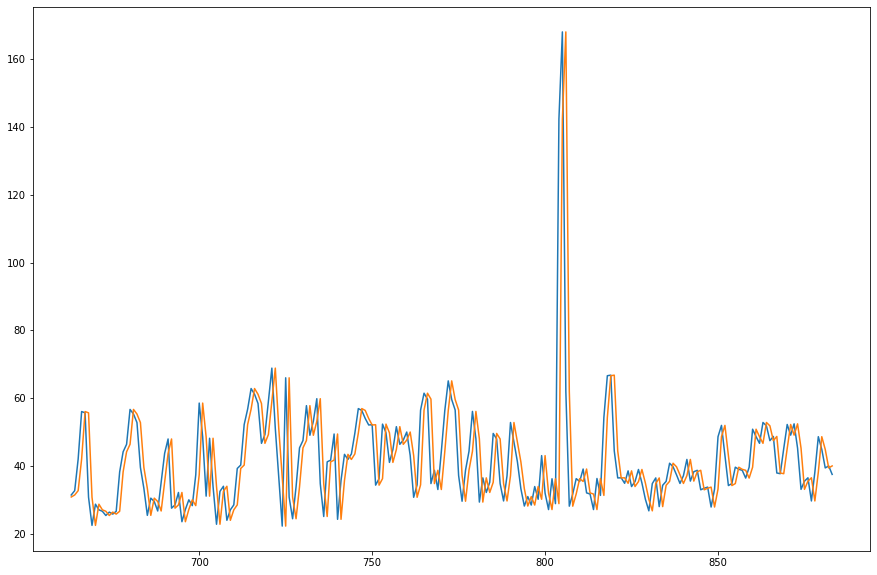

In [18]:
fig = plt.figure(figsize=(15, 10))
plt.plot(test_y.iloc[:])
plt.plot(predictions[:])
plt.show()

### ***SARIMA***

In [5]:
train, test = train_test_split(df_aqi_daily["AQI"], test_size=0.2, shuffle=False) 

In [6]:
model = SARIMAX(train, order=(2,0,0), seasonal_order=(1,1,1,7))
model_fit = model.fit()
print(model_fit.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                 AQI   No. Observations:                  707
Model:             SARIMAX(2, 0, 0)x(1, 1, [1], 7)   Log Likelihood               -2621.929
Date:                             Wed, 08 Jun 2022   AIC                           5253.859
Time:                                     19:44:23   BIC                           5276.614
Sample:                                 01-01-2020   HQIC                          5262.655
                                      - 12-07-2021                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9396      0.031     30.416      0.000       0.879       1.000
ar.L2         -0.2187      

In [7]:
predictions_sarima = model_fit.predict(start=len(train), end=len(train)+5)

In [8]:
arima_test_rmse = mean_squared_error(test.iloc[:6], predictions_sarima, squared=False)
arima_test_mae = mean_absolute_error(test.iloc[:6], predictions_sarima)
print("Test RMSE: %.3f" % arima_test_rmse, "\nTest MAE: %.3f" % arima_test_mae)

Test RMSE: 13.854 
Test MAE: 11.496


Not very good reasult, for naive model 5 days prediction gives rmse about 5 

### ***Random Forest***


For forest models we can use one day before feature or several day before target day, so lets see how many days we can use.

In [5]:
n = 30
col_aqi = ["AQI"]
cols_pollutant = [x for x in df_aqi_daily.columns if 'avg' in x]

In [6]:
error_dict = choose_day_number(col_aqi, df_aqi_daily, n, RandomForestRegressor(random_state=0))

May be we can use concentration instead of index

In [7]:
error_dict_pollutant = choose_day_number(cols_pollutant, df_aqi_daily, n, RandomForestRegressor(random_state=0))

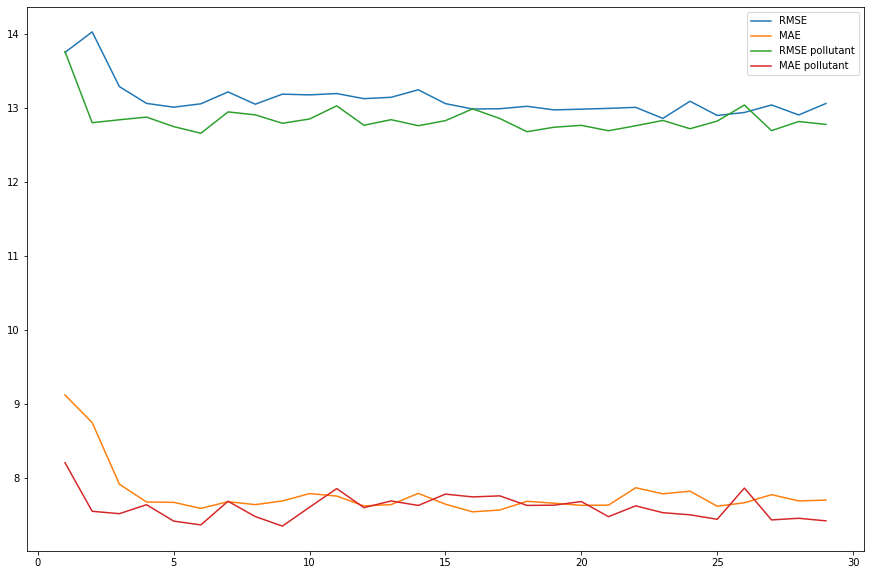

In [8]:
fig = plt.figure(figsize=(15, 10))
plt.plot([i for i in range(1, n)], error_dict["rmse"], label="RMSE")
plt.plot([i for i in range(1, n)], error_dict["mae"], label="MAE")
plt.plot([i for i in range(1, n)], error_dict_pollutant["rmse"], label="RMSE pollutant")
plt.plot([i for i in range(1, n)], error_dict_pollutant["mae"], label="MAE pollutant")
plt.legend()
plt.show()

about 5 days is optimal for pollutant concentration

Now we will be use this dataset for search hyperparameters

In [9]:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 15)]
max_depth = [int(x) for x in np.linspace(10, 110, num = 15)]
max_depth.append(None)
min_samples_split = [2, 5, 8, 10]
min_samples_leaf = [2, 4, 6, 8]
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [10]:
depth = 5
best_rf = search_best_params(cols_pollutant, df_aqi_daily, depth, 3, random_grid, RandomForestRegressor(random_state=0))
best_rf.best_params_

{'n_estimators': 1871,
 'min_samples_split': 10,
 'min_samples_leaf': 2,
 'max_depth': 110,
 'bootstrap': True}

In [12]:
rmse_rf, mae_rf = predict_best_model(df_aqi_daily, cols_pollutant, depth, RandomForestRegressor(random_state=0, **best_rf.best_params_))
print("Test RMSE: %.3f" % rmse_rf, "\nTest MAE: %.3f" % mae_rf)

Test RMSE: 12.655 
Test MAE: 7.352


In [13]:
col_aqi = ["AQI"]
error_xgb = choose_day_number(col_aqi, df_aqi_daily, n, XGBRegressor(random_state=0))

In [14]:
cols_pollutant = ['CO_avg', 'PM10_avg', 'NO2_avg', 'SO2_avg', 'O3_avg', 'PM2.5_avg']
error_xgb_pollutant = choose_day_number(cols_pollutant, df_aqi_daily, n, XGBRegressor(random_state=0))

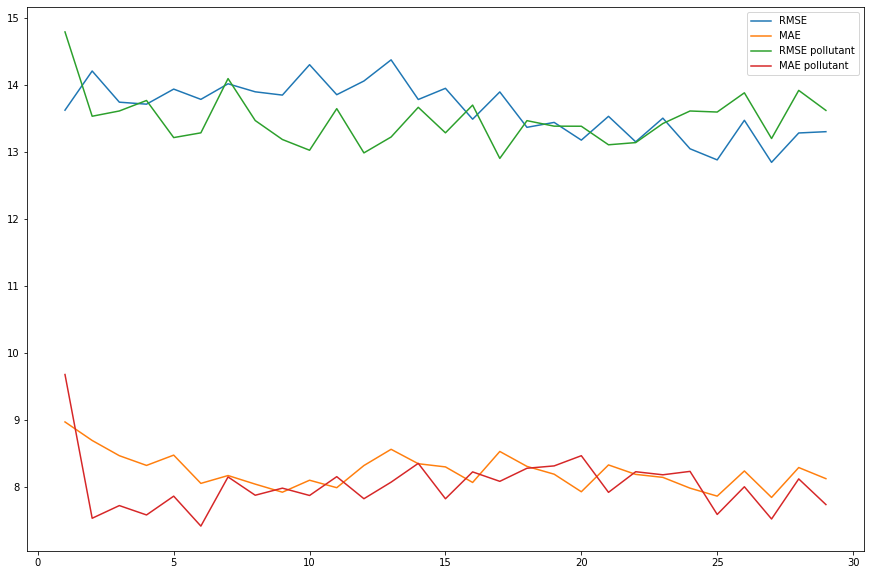

In [15]:
fig = plt.figure(figsize=(15, 10))
plt.plot([i for i in range(1, n)], error_xgb["rmse"], label="RMSE")
plt.plot([i for i in range(1, n)], error_xgb["mae"], label="MAE")
plt.plot([i for i in range(1, n)], error_xgb_pollutant["rmse"], label="RMSE pollutant")
plt.plot([i for i in range(1, n)], error_xgb_pollutant["mae"], label="MAE pollutant")
plt.legend()
plt.show()

In [40]:
params_xgb = {
    'n_estimators':[100, 500, 1000],
    'min_child_weight':[4,5],
    'gamma':[i/10.0 for i in range(3,6)],  
    'subsample':[i/10.0 for i in range(6,11)],
    'colsample_bytree':[i/10.0 for i in range(6,11)], 
    'max_depth': [2, 3, 4, 6, 7, 10, 15],
    'objective': ['reg:squarederror', 'reg:tweedie'],
    'booster': ['gbtree', 'gblinear'],
    'eval_metric': ['rmse'],
    'eta': [i/10.0 for i in range(3,6)],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
}

In [41]:
depth = 4
best_random_xgb = search_best_params(cols_pollutant, df_aqi_daily, depth, 3, params_xgb, XGBRegressor(random_state=0, verbosity = 0))
best_random_xgb.best_params_

{'subsample': 0.8,
 'objective': 'reg:squarederror',
 'n_estimators': 500,
 'min_child_weight': 5,
 'max_depth': 3,
 'learning_rate': 0.1,
 'gamma': 0.3,
 'eval_metric': 'rmse',
 'eta': 0.3,
 'colsample_bytree': 1.0,
 'booster': 'gblinear'}

In [14]:
depth = 25
rmse_xgb, mae_xgb = predict_best_model(df_aqi_daily, cols_pollutant, depth, XGBRegressor(random_state=0, **best_random_xgb.best_params_))
print("Test RMSE: %.3f" % rmse_xgb, "\nTest MAE: %.3f" % mae_xgb)

Test RMSE: 13.245 
Test MAE: 7.891


In [18]:
depth = 20
rmse_xgb, mae_xgb = predict_best_model(df_aqi_daily, cols_pollutant, depth, XGBRegressor(random_state=0, **best_random_xgb.best_params_))
print("Test RMSE: %.3f" % rmse_xgb, "\nTest MAE: %.3f" % mae_xgb)

Test RMSE: 12.519 
Test MAE: 7.191


In [24]:
depth = 15
rmse_xgb, mae_xgb = predict_best_model(df_aqi_daily, cols_pollutant, depth, XGBRegressor(random_state=0, **best_random_xgb.best_params_))
print("Test RMSE: %.3f" % rmse_xgb, "\nTest MAE: %.3f" % mae_xgb)

Test RMSE: 12.744 
Test MAE: 7.344


In [23]:
depth = 6
rmse_xgb, mae_xgb = predict_best_model(df_aqi_daily, cols_pollutant, depth, XGBRegressor(random_state=0, **best_random_xgb.best_params_))
print("Test RMSE: %.3f" % rmse_xgb, "\nTest MAE: %.3f" % mae_xgb)

Test RMSE: 11.990 
Test MAE: 7.252


In [30]:
depth = 5
rmse_xgb, mae_xgb = predict_best_model(df_aqi_daily, cols_pollutant, depth, XGBRegressor(random_state=0, **best_random_xgb.best_params_))
print("Test RMSE: %.3f" % rmse_xgb, "\nTest MAE: %.3f" % mae_xgb)

Test RMSE: 11.920 
Test MAE: 7.056


In [42]:
depth = 4
rmse_xgb, mae_xgb = predict_best_model(df_aqi_daily, cols_pollutant, depth, XGBRegressor(random_state=0, **best_random_xgb.best_params_))
print("Test RMSE: %.3f" % rmse_xgb, "\nTest MAE: %.3f" % mae_xgb)

Test RMSE: 11.145 
Test MAE: 6.996


In [20]:
depth = 1
rmse_xgb, mae_xgb = predict_best_model(df_aqi_daily, cols_pollutant, depth, XGBRegressor(random_state=0, **best_random_xgb.best_params_))
print("Test RMSE: %.3f" % rmse_xgb, "\nTest MAE: %.3f" % mae_xgb)

Test RMSE: 12.763 
Test MAE: 7.987


In [20]:
depth = 3
rmse_xgb, mae_xgb = predict_best_model(df_aqi_daily, cols_pollutant, depth, XGBRegressor(random_state=0, **best_random_xgb.best_params_))
print("Test RMSE: %.3f" % rmse_xgb, "\nTest MAE: %.3f" % mae_xgb)

Test RMSE: 11.500 
Test MAE: 7.022


In [38]:
depth = 5
best_best_params = {'subsample': 1.0,
 'objective': 'reg:squarederror',
 'n_estimators': 100,
 'min_child_weight': 4,
 'max_depth': 2,
 'gamma': 0.4,
 'eval_metric': 'rmse',
 'eta': 0.3,
 'colsample_bytree': 0.8,
 'booster': 'gblinear'}
rmse_xgb, mae_xgb = predict_best_model(df_aqi_daily, cols_pollutant, depth, XGBRegressor(random_state=0, **best_best_params))
print("Test RMSE: %.3f" % rmse_xgb, "\nTest MAE: %.3f" % mae_xgb)

Test RMSE: 11.368 
Test MAE: 7.188


In [45]:
depth = 4
best_best_params = {'subsample': 0.8,
 'objective': 'reg:squarederror',
 'n_estimators': 500,
 'min_child_weight': 5,
 'max_depth': 3,
 'learning_rate': 0.1,
 'gamma': 0.3,
 'eval_metric': 'rmse',
 'eta': 0.3,
 'colsample_bytree': 1.0,
 'booster': 'gblinear'}
rmse_xgb, mae_xgb = predict_best_model(df_aqi_daily, cols_pollutant, depth, XGBRegressor(random_state=0, **best_best_params))
print("Test RMSE: %.3f" % rmse_xgb, "\nTest MAE: %.3f" % mae_xgb)

Test RMSE: 11.152 
Test MAE: 6.984
